In [17]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


here we only use `input` samples with usual RNA-seq pipeline. 

In [ ]:
%%bash
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP' 'NT')
for treat in "${StringArray[@]}"; 
    do for f in bam/*human.$treat.input.bam; 
        do out=${f/.bam/.fc}; out=${out/bam/genecount}; 
            featureCounts -T 12 -O -t exon -g gene_id \
            -a /rumi/shams/genomes/hg38/gencode.v28.annotation.gtf -o $out $f; 
    done;
done

In [66]:
%%bash 
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP' 'NT')
for treat in "${StringArray[@]}"; 
    do for f in bam/*human.$treat.m6A.bam; 
        do out=${f/.bam/.fc}; out=${out/bam/genecount}; 
            featureCounts -T 12 -O -t exon -g gene_id \
            -a /rumi/shams/genomes/hg38/gencode.v28.annotation.gtf -o $out $f; 
    done;
done

### PCA

In [4]:
%%R 
library(DESeq2)
library(tidyverse)
library(ggplot2)
require(ggrepel)
library(patchwork)
library(feather)
gtf_df = read_feather('gtf_df.ft') %>% remove_rownames %>% column_to_rownames(var="ID")

pca = list(); vol = list(); hist = list()

In [5]:
%%R 
files = list.files(path = 'genecount',pattern=".fc$")
# meta 
reps <- c(rep('s23',10),rep('s24',10))
treat <- rep(c(rep('METTL14',2),rep('METTL3',2),rep('NT',2),rep('Virma',2),rep('WTAP',2)),2)
ip <- rep(c('input','m6A'),10)
conds <- c(paste(treat,ip, sep='.'))

# read files 
datalist <- lapply(files, function(x){read.table(file=paste('genecount/', x, sep = ""),skip=1,sep='\t',header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- paste(reps,treat,ip,sep='.')

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



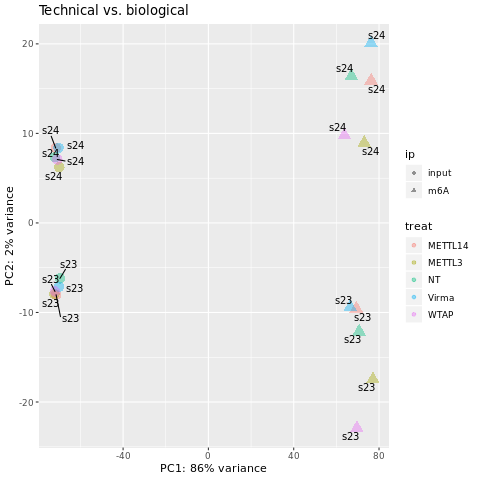

In [19]:
%%R
# design 
colData <- data.frame(cond = conds, rep = reps, ip = ip, row.names=colnames(m))
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond + rep)
dds
dds$cond <- relevel(dds$cond, ref='NT.input')
dds <- DESeq(dds)
# normalized counts
ncu <- counts(dds, normalized=TRUE)
# results 
res <- results(dds)
vsd <- varianceStabilizingTransformation(dds)
## PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
z$rep <- reps
z$ip <- ip
z$treat <- treat
percentVar <- round(100 * attr(z, "percentVar"))
pca <- ggplot(z, aes(PC1, PC2)) +
        ggtitle('Technical vs. biological') + 
        geom_point(aes(size = 2,  colour=treat, shape=ip), alpha = 4/10) +
        geom_text_repel(aes(label = rep),size = 3.5) +
        xlab(paste0("PC1: ",percentVar[1],"% variance")) +
        ylab(paste0("PC2: ",percentVar[2],"% variance")) +
        guides(size = FALSE) +
        theme()

ggsave("plots/all_PCAs.png", plot = pca, device = 'png', dpi = 300)
ggsave("plots/all_PCAs.pdf", plot = pca, device = 'pdf', dpi = 300)

pca

## Internal control 
only reading `input` sampels: 

In [6]:
%%R
options(repr.plot.width=4, repr.plot.height=4)

files = list.files(path = 'genecount',pattern=".input.fc$")
# meta 
reps <- c(rep('s23',5),rep('s24',5))
treat <- rep(c('METTL14','METTL3','NT','Virma','WTAP'),2)
conds = treat
# read files 
datalist <- lapply(files, function(x){read.table(file=paste('genecount/', x, sep = ""),skip=1,sep='\t',header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- paste(reps,conds,sep='.')

In [62]:
%%R 
all_res = list()
lfc.cutoff = 1
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    icond = c(grep(treat,colnames(m)), grep('NT',colnames(m)) )
    mm <- m[,icond]
    # design
    colData <- data.frame(cond= conds[icond],rep=reps[icond], row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond + rep)
    dds$cond <- relevel(dds$cond, ref='NT')
    dds <- DESeq(dds)
    res <- results(dds, contrast=c('cond',treat,'NT'))
    res0 <- data.frame(res)
    res <- data.frame(res)[c(!is.na(res$padj) & abs(res$log2FoldChange) > lfc.cutoff),c(2,1,3:6)]
    # idtransfer
    res0$name = gtf_df[rownames(res0),]
    res$name = gtf_df[rownames(res),]
    all_res[[treat]] <- res0
    # save files 
    write.table(res,file=paste('deseq/inputs_',treat,'_vs_NT.txt',sep=''), sep="\t", quote=FALSE, col.names=NA)
}

[1] "METTL14"
                       name baseMean log2FoldChange    pvalue      padj
ENSG00000145388.14  METTL14 231.6902    -0.34141970 0.3432071 0.9998984
ENSG00000146457.14     WTAP 532.6499     0.27842521 0.2549869 0.9998984
ENSG00000164944.11 KIAA1429 663.2608     0.03264867 0.8802465 0.9998984
ENSG00000165819.11   METTL3 682.4459    -0.03486790 0.8705401 0.9998984
[1] "METTL3"
                       name baseMean log2FoldChange      pvalue       padj
ENSG00000145388.14  METTL14 281.3092      0.2729448 0.406580557         NA
ENSG00000146457.14     WTAP 625.1083      0.7027947 0.001935877 0.08696554
ENSG00000164944.11 KIAA1429 693.4508      0.1893738 0.379007282 0.99856616
ENSG00000165819.11   METTL3 591.5949     -0.4419943 0.057697989 0.73893916
[1] "Virma"
                       name baseMean log2FoldChange      pvalue      padj
ENSG00000145388.14  METTL14 257.2336      0.1623479 0.629775307 0.9996953
ENSG00000146457.14     WTAP 538.0204      0.4565725 0.067968639 0.9996953
ENSG

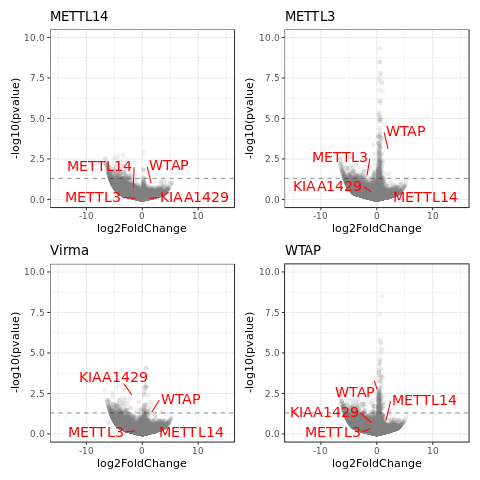

In [65]:
%%R 
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    res = all_res[[treat]]
    pval.cutoff = 0.05
    
    res$sig <- as.factor(res$pvalue < pval.cutoff)
    relevel(res$sig, ref=TRUE)
    print (treat)
    print (res[
        res$name == 'KIAA1429'| res$name == 'METTL14'|res$name == 'WTAP'| res$name == 'METTL3',
        c('name','baseMean','log2FoldChange','pvalue','padj')]
          )
    ## Volcano plot
    vol[[treat]] = res %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue))) +
                            geom_point(color = ifelse(
                                res$name == 'KIAA1429'| res$name == 'METTL14'|
                                res$name == 'WTAP'| res$name == 'METTL3',
                                "red", "grey50"),
                                alpha = 1/10) +
                            ggtitle(treat) +
                            xlim(c(-15,15)) +
                            ylim(c(0,10)) +
                            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
                            scale_color_manual(values = c("grey", "black")) +
                            theme_bw() + theme(legend.position="none") +
                            geom_text_repel(
                                data = res[
                                    res$name == 'KIAA1429'| res$name == 'METTL14'|
                                    res$name == 'WTAP'| res$name == 'METTL3',],
                                aes(label = name),
                                colour='red',
                                size = 3,
                                box.padding = unit(0.35, "lines"),
                                point.padding = unit(1, "lines")
                            )
}
v = vol$METTL14 + vol$METTL3 + vol$Virma + vol$WTAP
# ggsave("plots/internal_control_Volcanos.png", plot = v, device = 'png', dpi = 300)
# ggsave("plots/internal_control_Volcanos.pdf", plot = v, device = 'pdf', dpi = 300)
v

In [189]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] GenomicFeatures_1.32.3      AnnotationDbi_1.42.1       
 [3] rtracklayer_1.40.6          Biostrings_2.48.0          
 [5] XVector_0.20.0              Gviz_1.24.0                
 [7] patchwork_1.0.0             ggrepel_0.8.1              
 [9] forcats